# Models for Heart

## Importing useful libraries

In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import seaborn as sns

## Importing the data

In [2]:
datapath = './data/heart.csv'
data = pd.read_csv(datapath)
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
X_columns_drop = ['target', 'restecg', 'fbs']


X = data.drop(X_columns_drop, axis=1)
y = data['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

## Models

### XGBoost

In [4]:
def xgbooster(X, y):
    params = {'early_stopping_rounds':3, 'eval_set':[(X_test, y_test)], 'verbose':False}
    clf_xgb = xgb.XGBClassifier(n_estimators = 700, learning_rate = 0.0025, n_jobs = 12, use_label_encoder=False, verbosity=0)
    scores = cross_val_score(clf_xgb, X, y, cv=5, scoring='f1', fit_params=(params))
    print("Accuracy scores: ", ((scores.mean())*100), "%")
    return clf_xgb


In [5]:
clf_xgb = xgbooster(X, y)

Accuracy scores:  82.47119775723895 %


In [6]:
clf_xgb.fit(X_train, y_train, early_stopping_rounds=3, eval_set=[(X_test, y_test)], verbose=False)
prediction = clf_xgb.predict(X_test)
print("Accuracy Score: " + str(accuracy_score(y_test, prediction)))

Accuracy Score: 0.819672131147541


In [7]:
results = clf_xgb.evals_result()
# print(results)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_X = scaler.fit_transform(X)
scaled_X = pd.DataFrame(scaled_X, columns=X.columns)
scaled_X.head()

,age,sex,cp,trestbps,chol,thalach,exang,oldpeak,slope,ca,thal
0,0.708333,1.0,1.000000,0.481132,0.244292,0.603053,0.0,0.370968,0.0,0.0,0.333333
1,0.166667,1.0,0.666667,0.339623,0.283105,0.885496,0.0,0.564516,0.0,0.0,0.666667
2,0.250000,0.0,0.333333,0.339623,0.178082,0.770992,0.0,0.225806,1.0,0.0,0.666667
3,0.562500,1.0,0.333333,0.245283,0.251142,0.816794,0.0,0.129032,1.0,0.0,0.666667
4,0.583333,0.0,0.000000,0.245283,0.520548,0.702290,1.0,0.096774,1.0,0.0,0.666667


In [9]:
xgbooster(scaled_X, y)

Accuracy scores:  82.5892551143695 %


XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.0025, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=700, n_jobs=12, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None, verbosity=0)

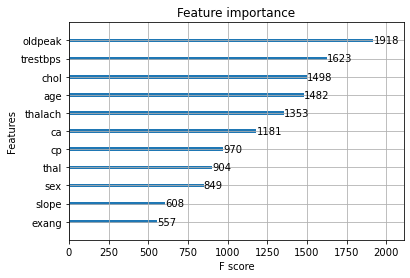

<Figure size 1152x864 with 0 Axes>

In [10]:
xgb.plot_importance(clf_xgb)
plt.figure(figsize = (16, 12))
plt.show()

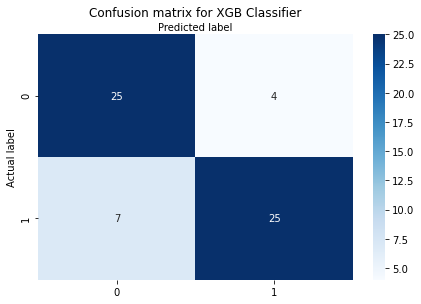

In [11]:
from sklearn.metrics import confusion_matrix


predict = clf_xgb.predict(X_test)
confusion_matrix = confusion_matrix(y_test,predict)
class_names = [0,1]
fig,ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks,class_names)
plt.yticks(tick_marks,class_names)
sns.heatmap(pd.DataFrame(confusion_matrix), annot = True, cmap = 'Blues', fmt = 'g')
ax.xaxis.set_label_position('top')
plt.tight_layout()
plt.title('Confusion matrix for XGB Classifier')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

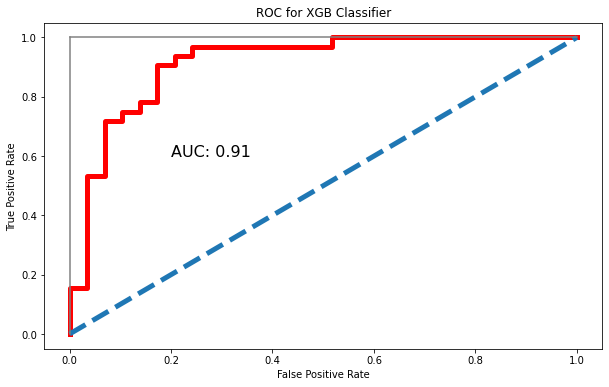

In [12]:
from sklearn.metrics import roc_auc_score,roc_curve

y_probabilities = clf_xgb.predict_proba(X_test)[:,1]

false_positive_rate_xgb, true_positive_rate_xgb, threshold_xgb = roc_curve(y_test,y_probabilities)

plt.figure(figsize=(10,6))
plt.title('ROC for XGB Classifier')
plt.plot(false_positive_rate_xgb, true_positive_rate_xgb, linewidth=5, color='red')
plt.plot([0,1],ls='--',linewidth=5)
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.text(0.2,0.6,'AUC: {:.2f}'.format(roc_auc_score(y_test,y_probabilities)),size= 16)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

## Deap Lerarning

In [13]:
from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(min_delta=0.001,
    patience=5,
    restore_best_weights=True,)

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# model = keras.Sequential([
#     layers.BatchNormalization(input_shape=[11]),
#     layers.Dense(units=1024, activation='relu'),
#     layers.Dropout(rate=0.3),
#     layers.BatchNormalization(),
#     layers.Dense(units=1024, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dense(units=1, activation='sigmoid')
# ])

model = keras.Sequential([
    layers.BatchNormalization(input_shape=[11]),
    layers.Dense(units=512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(units=256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(units=1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

Epoch 1/1000
1/1 [==============================] - 0s 38ms/step - loss: 0.6147 - binary_accuracy: 0.7202 - val_loss: 3.3545 - val_binary_accuracy: 0.4286
Epoch 2/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.5246 - binary_accuracy: 0.7720 - val_loss: 2.3893 - val_binary_accuracy: 0.4286
Epoch 3/1000
1/1 [==============================] - 0s 19ms/step - loss: 0.4029 - binary_accuracy: 0.8135 - val_loss: 1.7613 - val_binary_accuracy: 0.4286
Epoch 4/1000
1/1 [==============================] - 0s 20ms/step - loss: 0.3546 - binary_accuracy: 0.8497 - val_loss: 1.3427 - val_binary_accuracy: 0.4286
Epoch 5/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.3254 - binary_accuracy: 0.8446 - val_loss: 1.0921 - val_binary_accuracy: 0.4286
Epoch 6/1000
1/1 [==============================] - 0s 18ms/step - loss: 0.3207 - binary_accuracy: 0.8446 - val_loss: 0.9905 - val_binary_accuracy: 0.4286
Epoch 7/1000
1/1 [==============================] - 0s 19ms/step - los

<AxesSubplot:title={'center':'Accuracy'}>

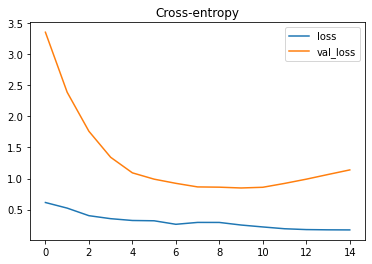

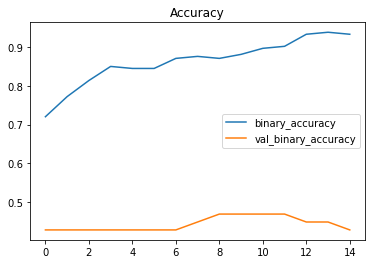

In [31]:
history = model.fit(X_train, y_train, batch_size = 512, epochs=1000, verbose=True, validation_split=0.2, callbacks=[early_stopping])
# history_df = pd.DataFrame(history.history)
# history_df.loc[0:, ['loss', 'val_loss']].plot()
# print(("Minimum Validation Loss: {:0.4f}").format(history_df['val_loss'].min()))


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

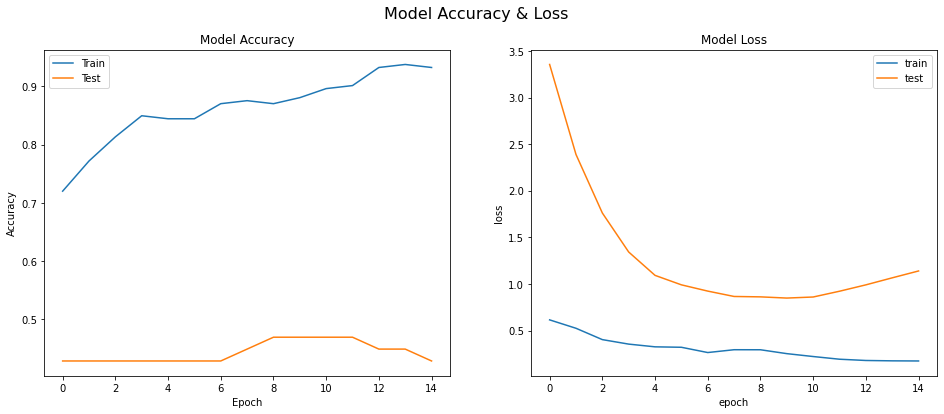

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model Loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'test'])
plt.suptitle("Model Accuracy & Loss",fontsize=16)

ax1.plot(history.history['binary_accuracy'])
ax1.plot(history.history['val_binary_accuracy'])
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(['Train', 'Test'])

plt.show()

In [33]:
from sklearn.metrics import confusion_matrix

print(X_test.head())
predict = model.predict(X_test.head())
print(predict)
print(y_test.head())
# confusion_matrix = confusion_matrix(y_test,predict)
# class_names = [0,1]
# fig,ax = plt.subplots()
# tick_marks = np.arange(len(class_names))
# plt.xticks(tick_marks,class_names)
# plt.yticks(tick_marks,class_names)
# sns.heatmap(pd.DataFrame(confusion_matrix), annot = True, cmap = 'Blues', fmt = 'g')
# ax.xaxis.set_label_position('top')
# plt.tight_layout()
# plt.title('Confusion matrix for XGB Classifier')
# plt.ylabel('Actual label')
# plt.xlabel('Predicted label')
# plt.show()

     age  sex  cp  trestbps  chol  thalach  exang  oldpeak  slope  ca  thal
179   57    1   0       150   276      112      1      0.6      1   1     1
228   59    1   3       170   288      159      0      0.2      1   0     3
111   57    1   2       150   126      173      0      0.2      2   1     3
246   56    0   0       134   409      150      1      1.9      1   2     3
60    71    0   2       110   265      130      0      0.0      2   1     2
[[0.09010801]
 [0.1615814 ]
 [0.24159852]
 [0.10312614]
 [0.25076815]]
179    0
228    0
111    1
246    0
60     1
Name: target, dtype: int64


In [39]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1, scoring='accuracy').fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

ValueError: Classification metrics can't handle a mix of binary and continuous targets